In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)


In [2]:
application_train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_app = pd.read_csv('previous_application.csv')
installments = pd.read_csv('installments_payments.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
credit_card = pd.read_csv('credit_card_balance.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


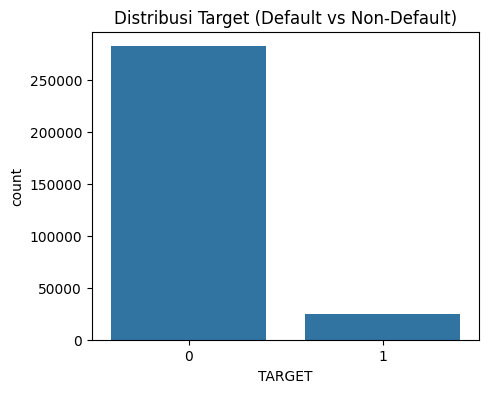

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


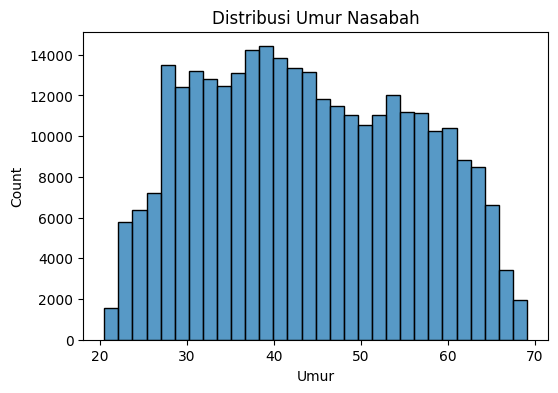

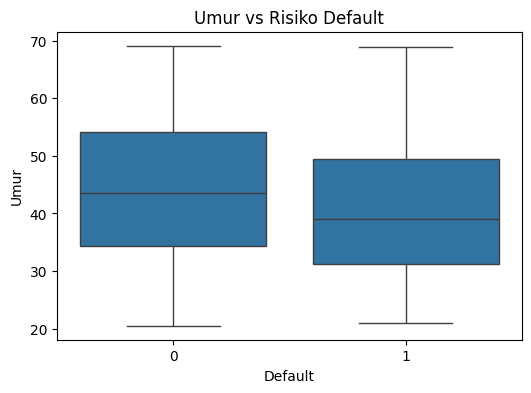

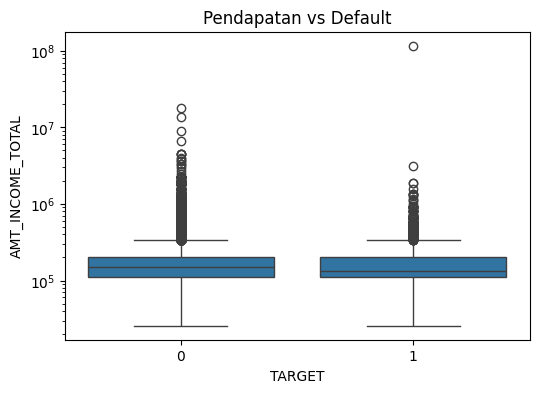

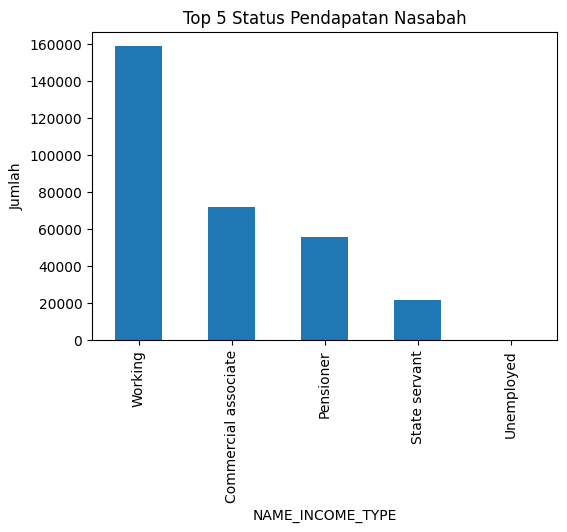

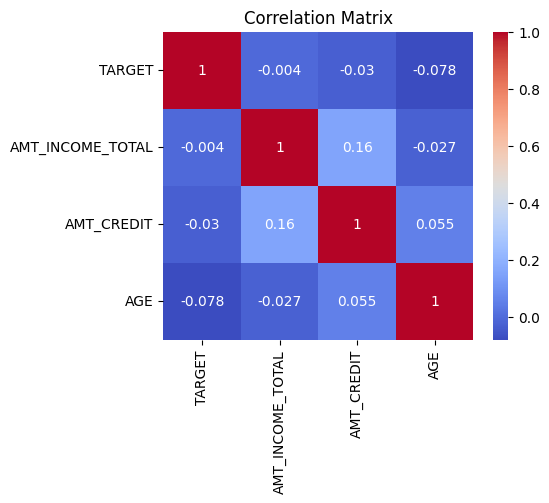

In [23]:
application_train.info()
application_train.describe()

# Distribusi Target
plt.figure(figsize=(5,4))
sns.countplot(x='TARGET', data=application_train)
plt.title('Distribusi Target (Default vs Non-Default)')
plt.show()

print(application_train['TARGET'].value_counts(normalize=True))

# Distribusi Umur
application_train['AGE'] = application_train['DAYS_BIRTH'] / -365

plt.figure(figsize=(6,4))
sns.histplot(application_train['AGE'], bins=30)
plt.title('Distribusi Umur Nasabah')
plt.xlabel('Umur')
plt.show()

# Umur vs Default (FIX)
plt.figure(figsize=(6,4))
sns.boxplot(
    x='TARGET',
    y='AGE',
    data=application_train
)
plt.title('Umur vs Risiko Default')
plt.xlabel('Default')
plt.ylabel('Umur')
plt.show()

# Pendapatan vs Default
plt.figure(figsize=(6,4))
sns.boxplot(
    x='TARGET',
    y='AMT_INCOME_TOTAL',
    data=application_train
)
plt.yscale('log')
plt.title('Pendapatan vs Default')
plt.show()

# Status Pendapatan
top_job = application_train['NAME_INCOME_TYPE'].value_counts().head(5)

plt.figure(figsize=(6,4))
top_job.plot(kind='bar')
plt.title('Top 5 Status Pendapatan Nasabah')
plt.ylabel('Jumlah')
plt.show()

# Korelasi
corr = application_train[['TARGET','AMT_INCOME_TOTAL','AMT_CREDIT','AGE']].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [4]:
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': 'mean',
    'STATUS': 'nunique'
}).reset_index()


In [5]:
bureau = bureau.merge(bureau_balance_agg, on='SK_ID_BUREAU', how='left')

bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'DAYS_CREDIT': 'mean',
    'CREDIT_DAY_OVERDUE': 'mean',
    'MONTHS_BALANCE': 'mean',
    'STATUS': 'mean'
})

bureau_agg.columns = bureau_agg.columns.map('_'.join)


In [6]:
prev_agg = previous_app.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': 'mean',
    'AMT_CREDIT': 'mean',
    'DAYS_DECISION': 'mean'
})

prev_agg.columns = ['PREV_APP_MEAN','PREV_CREDIT_MEAN','PREV_DECISION_MEAN']


In [7]:
installments['PAYMENT_DIFF'] = (
    installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']
)

inst_agg = installments.groupby('SK_ID_CURR').agg({
    'PAYMENT_DIFF': 'mean',
    'DAYS_ENTRY_PAYMENT': 'mean'
})

inst_agg.columns = ['PAYMENT_DIFF_MEAN','PAYMENT_DAYS_MEAN']


In [8]:
pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'mean',
    'SK_DPD': 'mean',
    'SK_DPD_DEF': 'mean'
})

pos_agg.columns = ['POS_MONTHS_MEAN','POS_DPD_MEAN','POS_DPD_DEF_MEAN']


In [9]:
credit_agg = credit_card.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'SK_DPD': 'mean',
    'SK_DPD_DEF': 'mean'
})

credit_agg.columns = [
    'CC_BALANCE_MEAN',
    'CC_LIMIT_MEAN',
    'CC_DPD_MEAN',
    'CC_DPD_DEF_MEAN'
]


In [10]:
data = application_train.merge(bureau_agg, on='SK_ID_CURR', how='left')
data = data.merge(prev_agg, on='SK_ID_CURR', how='left')
data = data.merge(inst_agg, on='SK_ID_CURR', how='left')
data = data.merge(pos_agg, on='SK_ID_CURR', how='left')
data = data.merge(credit_agg, on='SK_ID_CURR', how='left')


In [21]:
for col in data.columns:
    if data[col].dtype != 'object':
        data[col] = data[col].fillna(data[col].median())
    else:
        data[col] = data[col].fillna('Unknown')


In [12]:
le = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col])


In [13]:
X = data.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [15]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [16]:
y_pred_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)

print("AUC Score:", auc)
print(classification_report(y_test, model.predict(X_test)))


AUC Score: 0.7514404325271415
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503



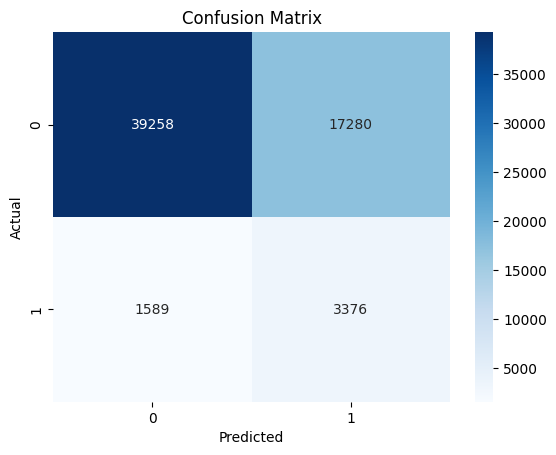

In [17]:
cm = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


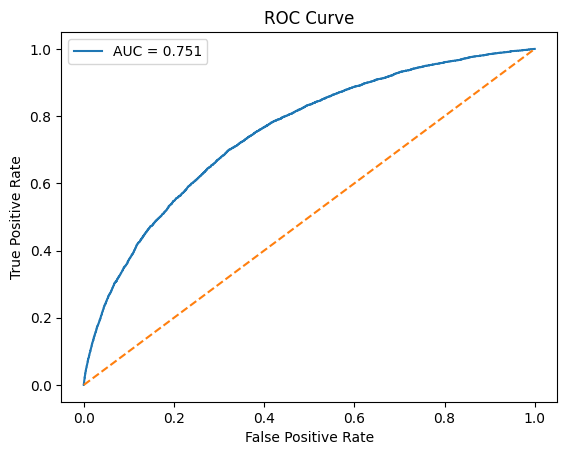

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [19]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance.head(10))


                   Feature  Coefficient
21          FLAG_EMP_PHONE     7.648409
16           DAYS_EMPLOYED     7.596906
6               AMT_CREDIT     0.857427
71       BASEMENTAREA_MEDI     0.411817
127       PREV_CREDIT_MEAN     0.391584
45         YEARS_BUILD_AVG     0.320416
80   LIVINGAPARTMENTS_MEDI     0.317032
53          LIVINGAREA_AVG     0.243245
42          APARTMENTS_AVG     0.227562
4             CNT_CHILDREN     0.216138


In [20]:
risk_df = pd.DataFrame({'Probability_Default': y_pred_proba})

risk_df['Risk_Level'] = pd.cut(
    risk_df['Probability_Default'],
    bins=[0, 0.3, 0.6, 1],
    labels=['Low Risk','Medium Risk','High Risk']
)

decision_policy = risk_df['Risk_Level'].map({
    'Low Risk': 'Approve',
    'Medium Risk': 'Review',
    'High Risk': 'Reject'
})

print(decision_policy.value_counts())


Risk_Level
Review     28855
Approve    20014
Reject     12634
Name: count, dtype: int64
